In [1]:
import sys

for a in ['', '/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python37.zip',
          '/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7',
          '/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/lib-dynload',
          '/Users/kristjan.roosild/.local/lib/python3.7/site-packages',
          '/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages',
          '/Users/kristjan.roosild/projects/donkeycar',
          '/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg']:
    sys.path.append(a)

In [2]:
from donkeycar.parts.keras import KerasLinear, KerasLinearOnlySteering, \
    KerasInterpreter, KerasLSTMOnlySteering, Keras3D_CNNOnlySteering, KerasMemoryOnlySteering

import donkeycar as dk

import math
import os
from typing import List, Dict, Union, Tuple

from donkeycar.config import Config
from donkeycar.parts.keras import KerasPilot
from donkeycar.pipeline.database import PilotDatabase
from donkeycar.pipeline.sequence import TubRecord, TubSequence, TfmIterator
from donkeycar.pipeline.types import TubDataset
from donkeycar.pipeline.augmentations import ImageAugmentation
from donkeycar.utils import normalize_image, train_test_split
import tensorflow as tf
import numpy as np


class BatchSequence(object):
    """
    The idea is to have a shallow sequence with types that can hydrate
    themselves to np.ndarray initially and later into the types required by
    tf.data (i.e. dictionaries or np.ndarrays).
    """

    def __init__(self,
                 model: KerasPilot,
                 config: Config,
                 records: List[TubRecord],
                 is_train: bool) -> None:
        self.model = model
        self.config = config
        self.sequence = TubSequence(records)
        self.batch_size = self.config.BATCH_SIZE
        self.is_train = is_train
        self.augmentation = ImageAugmentation(config, 'AUGMENTATIONS')
        self.transformation = ImageAugmentation(config, 'TRANSFORMATIONS')
        self.pipeline = self._create_pipeline()

    def __len__(self) -> int:
        return math.ceil(len(self.pipeline) / self.batch_size)

    def image_processor(self, img_arr):
        """ Transformes the images and augments if in training. Then
            normalizes it. """
        img_arr = self.transformation.run(img_arr)
        if self.is_train:
            img_arr = self.augmentation.run(img_arr)
        norm_img = normalize_image(img_arr)
        return norm_img

    def _create_pipeline(self) -> TfmIterator:
        """ This can be overridden if more complicated pipelines are
            required """

        # 1. Initialise TubRecord -> x, y transformations
        def get_x(record: TubRecord) -> Dict[str, Union[float, np.ndarray]]:
            """ Extracting x from record for training"""
            out_tuple = self.model.x_transform_and_process(
                record, self.image_processor)
            # convert tuple to dictionary which is understood by tf.data
            out_dict = self.model.x_translate(out_tuple)
            return out_dict

        def get_y(record: TubRecord) -> Dict[str, Union[float, np.ndarray]]:
            """ Extracting y from record for training """
            y0 = self.model.y_transform(record)
            y1 = self.model.y_translate(y0)
            return y1

        # 2. Build pipeline using the transformations
        pipeline = self.sequence.build_pipeline(x_transform=get_x,
                                                y_transform=get_y)
        return pipeline

    def create_tf_data(self) -> tf.data.Dataset:
        """ Assembles the tf data pipeline """
        dataset = tf.data.Dataset.from_generator(
            generator=lambda: self.pipeline,
            output_types=self.model.output_types(),
            output_shapes=self.model.output_shapes())
        return dataset.repeat().batch(self.batch_size)


def get_model_train_details(database: PilotDatabase, model: str = None) -> Tuple[str, int]:
    if not model:
        model_name, model_num = database.generate_model_name()
    else:
        model_name, model_num = os.path.abspath(model), 0
    return model_name, model_num


________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.2.1 ...


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:

cfg = dk.load_config(config_path='/Users/kristjan.roosild/mycar/config.py')

cfg.TRANSFORMATIONS = ['CROP']
cfg.ROI_CROP_TOP = 60

input_shape = (cfg.IMAGE_H, cfg.IMAGE_W, cfg.IMAGE_DEPTH)

tub_names_80_speed = [
    '1-1-CC-80',
    '2-1-CW-80',
    '4-1-CC-80',
]

tub_names_85_speed = [
    '1-3-CC-85',
    '2-3-CW-85',
    '3-3-CW-85',
    '4-3-CC-85'
]

tub_names_90_speed = [
    '1-2-CC-90',
    '2-2-CW-90',
    '3-2-CW-90',
    '4-2-CC-90',
]


def load_records(tub_name):
    return TubDataset(
        config=cfg,
        tub_paths=[os.path.expanduser('/Users/kristjan.roosild/OneDrive/kool/maka/data/' + tub_name)],
        seq_size=0).get_records()


tub_records_80_speed = {tn: load_records(tn) for tn in tub_names_80_speed}
tub_records_85_speed = {tn: load_records(tn) for tn in tub_names_85_speed}
tub_records_90_speed = {tn: load_records(tn) for tn in tub_names_90_speed}


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/1-1-CC-80']


loading config file: /Users/kristjan.roosild/mycar/config.py
loading personal config over-rides from myconfig.py
Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/1-1-CC-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/2-1-CW-80']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/2-1-CW-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/4-1-CC-80']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/4-1-CC-80/catalog_5.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/1-3-CC-85']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/1-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/2-3-CW-85']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/2-3-CW-85/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/3-3-CW-85']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/3-3-CW-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/4-3-CC-85']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/4-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/1-2-CC-90']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/1-2-CC-90/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/2-2-CW-90']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/2-2-CW-90/catalog_2.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/3-2-CW-90']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/3-2-CW-90/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['/Users/kristjan.roosild/OneDrive/kool/maka/data/4-2-CC-90']


Using catalog /Users/kristjan.roosild/OneDrive/kool/maka/data/4-2-CC-90/catalog_7.catalog


In [4]:

def prep_fold_data(kl, cfg, data):
    training_records, validation_records = train_test_split(data, shuffle=False,
                                                            test_size=(1. - cfg.TRAIN_TEST_SPLIT))
    print(f'Records # Training {len(training_records)}')
    print(f'Records # Validation {len(validation_records)}')
    # We need augmentation in validation when using crop / trapeze
    training_pipe = BatchSequence(kl, cfg, training_records, is_train=True)
    validation_pipe = BatchSequence(kl, cfg, validation_records, is_train=False)
    tune = tf.data.experimental.AUTOTUNE
    dataset_train = training_pipe.create_tf_data().prefetch(tune)
    dataset_validate = validation_pipe.create_tf_data().prefetch(tune)
    train_size = len(training_pipe)
    val_size = len(validation_pipe)
    assert val_size > 0, "Not enough validation data, decrease the batch size or add more data."
    return dataset_train, dataset_validate, train_size, val_size


import wandb


def init_wandb(tub, kl):
    config = {
        "tub": tub,
        "model": str(kl)
    }
    wandb.init(project="master-thesis", entity="kristjan", config=config)


def train(tub, kl, model_path, cfg, data):
    dataset_train, dataset_validate, train_size, val_size = prep_fold_data(kl, cfg, data)
    init_wandb(tub, kl)
    history = kl.train(model_path=model_path,
                       train_data=dataset_train,
                       train_steps=train_size,
                       batch_size=cfg.BATCH_SIZE,
                       validation_data=dataset_validate,
                       validation_steps=val_size,
                       epochs=cfg.MAX_EPOCHS,
                       verbose=cfg.VERBOSE_TRAIN,
                       min_delta=cfg.MIN_DELTA,
                       patience=cfg.EARLY_STOP_PATIENCE,
                       show_plot=cfg.SHOW_PLOT)

    return history


def mse(v1, v2):
    return np.mean((np.array(v1) - np.array(v2)) ** 2)

In [5]:
def get_loss(kl, test_records):
    pipe = BatchSequence(kl, cfg, test_records, is_train=False)
    steps = len(pipe)
    tune = tf.data.experimental.AUTOTUNE
    dataset = pipe.create_tf_data().prefetch(tune)
    test_preds = kl.interpreter.model.predict(
        dataset,
        workers=2,
        use_multiprocessing=True,
        steps=steps,
        verbose=1)[0]
    ground_truth = [r.underlying['user/angle'] for r in test_records]
    return mse(ground_truth, test_preds)


'KerasLinearOnlySteering'

In [15]:

def train_tub_1_frame_model(tub_name: str, train_records: list, cfg: Config):
    input_shape = (cfg.IMAGE_H, cfg.IMAGE_W, cfg.IMAGE_DEPTH)
    kl = KerasLinearOnlySteering(interpreter=KerasInterpreter(), input_shape=input_shape)
    model_name = f'{str(kl)}-tub-{tub_name}'
    model_path = f'/Users/kristjan.roosild/OneDrive/kool/maka/models/{model_name}.h5'
    train(tub_name, kl, model_path, cfg, train_records)
    return kl

def get_test_metrics(model, tub_name, tub_records_80_speed, tub_records_85_speed, tub_records_90_speed):

    test_losses_for_80_speed = {}
    test_losses_for_85_speed = {}
    test_losses_for_90_speed = {}

    print(f'Getting 80-speed mse-s for model trained with {tub_name}')
    for test_tub_name, test_records in tub_records_80_speed.items():
        mse_80_speed = get_loss(model, test_records)
        test_losses_for_80_speed[test_tub_name] = mse_80_speed
        wandb.run.summary["80_speed_test_loss"] = mse_80_speed
        print(f'80 speed mse for test tub {test_tub_name} is {mse_80_speed}')

    print(f'Getting 85-speed mse-s for model trained with {tub_name}')
    for test_tub_name, test_records in tub_records_85_speed.items():
        mse_85_speed = get_loss(model, test_records)
        test_losses_for_85_speed[test_tub_name] = mse_85_speed
        wandb.run.summary["85_speed_test_loss"] = mse_85_speed
        print(f'85 speed mse for test tub {test_tub_name} is {mse_85_speed}')

    print(f'Getting 90-speed mse-s for model trained with {tub_name}')
    for test_tub_name, test_records in tub_records_90_speed.items():
        if test_tub_name == tub_name:
            continue
        mse_90_speed = get_loss(model, test_records)
        test_losses_for_90_speed[test_tub_name] = mse_90_speed
        wandb.run.summary["90_speed_test_loss"] = mse_90_speed
        print(f'90 speed mse for test tub {test_tub_name} is {mse_90_speed}')

    return test_losses_for_80_speed, test_losses_for_85_speed, test_losses_for_90_speed

INFO:donkeycar.parts.keras:Created KerasLinearOnlySteering with interpreter: KerasInterpreter


Records # Training 80
Records # Validation 20


epoch,▁▂▃▃▄▅▆▆▇█
loss,▅▅▃▁█▁▅▂▃▄
n_outputs0_loss,▅▅▃▁█▁▅▂▃▄
n_outputs1_loss,█▆▁▅▇▇▇▆▅▅
val_loss,▁█▂▁▁▁▂▄▄▅
val_n_outputs0_loss,▁█▂▁▁▁▂▄▄▅
val_n_outputs1_loss,▇▁▆███▇▅▄▄
best_epoch,4
best_val_loss,1.09463
epoch,9
loss,0.53578


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4281 - n_outputs0_loss: 0.4281 - n_outputs1_loss: 0.7581
Epoch 00001: val_loss improved from inf to 5.10648, saving model to /Users/kristjan.roosild/OneDrive/kool/maka/models/KerasLinearOnlySteering-tub-1-2-CC-90.h5
1/1 [==============================] - 1s 1s/step - loss: 0.4281 - n_outputs0_loss: 0.4281 - n_outputs1_loss: 0.7581 - val_loss: 5.1065 - val_n_outputs0_loss: 5.1065 - val_n_outputs1_loss: 0.2563
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 3.1852 - n_outputs0_loss: 3.1852 - n_outputs1_loss: 0.3219
Epoch 00002: val_loss improved from 5.10648 to 1.30229, saving model to /Users/kristjan.roosild/OneDrive/kool/maka/models/KerasLinearOnlySteering-tub-1-2-CC-90.h5
1/1 [==============================] - 1s 1s/step - loss: 3.1852 - n_outputs0_loss: 3.1852 - n_outputs1_loss: 0.3219 - val_loss: 1.3023 - val_n_outputs0_loss: 1.3023 - val_n_outputs1_loss: 0.7644
Epoch 3/100
1/1 [=================

INFO:donkeycar.parts.keras:Created KerasLinearOnlySteering with interpreter: KerasInterpreter


90 speed mse for test tub 4-2-CC-90 is 0.6761212476221078
Records # Training 80
Records # Validation 20


epoch,▁▂▃▄▅▅▆▇█
loss,▁█▁▁▂▁▁▁▁
n_outputs0_loss,▁█▁▁▂▁▁▁▁
n_outputs1_loss,▄▁▄▅▅▅▆▆█
val_loss,█▁▁▁▁▁▁▂▂
val_n_outputs0_loss,█▁▁▁▁▁▁▂▂
val_n_outputs1_loss,▁▅▆▆▆▆▇██
80_speed_test_loss,0.54527
85_speed_test_loss,0.55418
90_speed_test_loss,0.67612
best_epoch,3


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2535 - n_outputs0_loss: 0.2535 - n_outputs1_loss: 0.7971
Epoch 00001: val_loss improved from inf to 0.25028, saving model to /Users/kristjan.roosild/OneDrive/kool/maka/models/KerasLinearOnlySteering-tub-2-2-CW-90.h5
1/1 [==============================] - 1s 644ms/step - loss: 0.2535 - n_outputs0_loss: 0.2535 - n_outputs1_loss: 0.7971 - val_loss: 0.2503 - val_n_outputs0_loss: 0.2503 - val_n_outputs1_loss: 0.6992
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3691 - n_outputs0_loss: 0.3691 - n_outputs1_loss: 0.6749
Epoch 00002: val_loss improved from 0.25028 to 0.05387, saving model to /Users/kristjan.roosild/OneDrive/kool/maka/models/KerasLinearOnlySteering-tub-2-2-CW-90.h5
1/1 [==============================] - 0s 443ms/step - loss: 0.3691 - n_outputs0_loss: 0.3691 - n_outputs1_loss: 0.6749 - val_loss: 0.0539 - val_n_outputs0_loss: 0.0539 - val_n_outputs1_loss: 0.7999
Epoch 3/100
1/1 [===========

KeyboardInterrupt: 

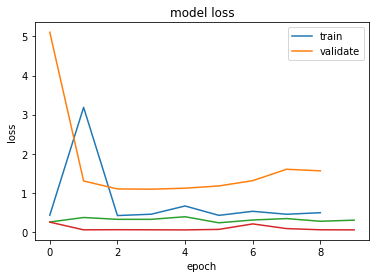

In [16]:
from collections import defaultdict

losses = defaultdict(dict)

for tub_name, records in tub_records_90_speed.items():
    model = train_tub_1_frame_model(tub_name, records, cfg)

    test_losses_for_80_speed, test_losses_for_85_speed, test_losses_for_90_speed = get_test_metrics(
        model, tub_name, tub_records_80_speed, tub_records_85_speed, tub_records_90_speed
    )

    losses.update(test_losses_for_80_speed)
    losses.update(test_losses_for_85_speed)
    losses.update(test_losses_for_90_speed)

In [ ]:
Creating augmentation CROP